# Generate Cat Images By Using Variational Autoencoder (VAE)

If you google "The benefit of watching cat videos", there are 2,710,000,000 results in 0.61 seconds about that
Science proved that watching cat videos make you happy. This semester has been tough so I am generating cat images with the hope of feeling happier after seeing the result. 
Cat images can be generated by using Variational Autoencoder (VAE) or generative adversarial networks (GAN)
The code below uses VAE method

Reference: https://www.tensorflow.org/tutorials/generative/cvae

## Import libraries

In [2]:
import gzip
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras import backend as K
from tensorflow.keras.optimizers import Adam

## Load the data

In [2]:
image_dir = "cats/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:5]

['cats/1.jpg',
 'cats/10.jpg',
 'cats/100.jpg',
 'cats/1000.jpg',
 'cats/10000.jpg']

## Preprocessing

In [3]:
# preprocess
#define the image size of 64 so we can resize all images to the same size
image_size = 64

def preprocess(image):
    image = tf.io.read_file(image)
    #Decode JPEG-encoded images to uint8 tensor
    image = tf.io.decode_jpeg(image) 
    #Casts tensors to a new type_int32
    image = tf.cast(image, tf.float32)
    #Normalization (resize and scale images)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    #Reshape images to three dimession for seperating RGB layers
    image = tf.reshape(image, shape = (image_size, image_size, 3,))
    return image

## Training dataset

In [4]:
batch_size = 128
#Build TensorFlow input pipelines
training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
#shuffle dataset
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

Load one batch at a time can help us avoid loading all images at once and get out of memory errors

In [5]:
len(training_dataset) 
#124 batchs

124

## Visualize the input

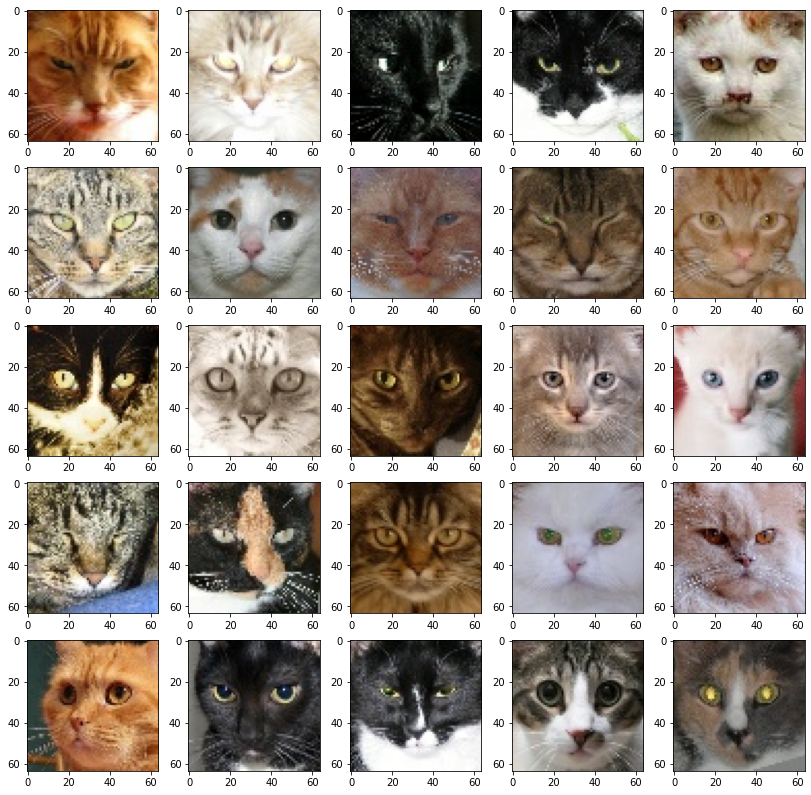

In [6]:
# visualize some of them
#make 5x5 grid and take 25 samples from training dataset and store them to sample list 
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

## Build the model

### Build the encoder

In [8]:
#Input shape of encoder is the shape of the image (64,64,3)
encoder_input = Input(shape = (64,64,3))
#The use activation function is LeakyReLU because it resolves dying ReLU Problem
x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)
#convert convert all feature matrices into vector and attach a dense layer
x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

### Build the sample layer (bottleneck)

In [9]:
latent_dim = 512
# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

The model from the encoder to the bottlebeck part

In [10]:
encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   51264       batch_normalization[0][0]        
____________________________________________________________________________________________

### Build the decoder

In [11]:
decoder = Sequential()
#first layer is a normal dense layer which will take input from latent vector
#Use batch normalization after every layer
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(512, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())


#For the last transpose layer we have three feature matrices represents red green and blue channel of generated image
decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         6554112   
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       3

### Loss function 

In [12]:
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [13]:
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 512), (None, 13802688    input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 3)    19790223    encoder[0][2]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 512)          0           encoder[0][1]                    
________________________________________________________________________________________________

## Build function to save images while learning

In [14]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    #5x5 grids, take 25 images
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "output1/"
    #If the directory isn't exist then, make one with the same name
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    #The name of the images are the names of current epoch and step
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

## Train VAE

In [15]:
#Save random images of every epoch so we can see how the images improve in every epoch
random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            #for every 10th epoch save the result of whatever model learns 
            #and print summary about what is the current loss for a particular epoch and step
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

Epoch:  1
Epoch: 1 - Step: 0 - MSE loss: 0.0698945 - KL loss: 0.00045627996
Epoch: 1 - Step: 1 - MSE loss: 0.06871609 - KL loss: 0.00042247615
Epoch: 1 - Step: 2 - MSE loss: 0.0759115 - KL loss: 0.0003448661
Epoch: 1 - Step: 3 - MSE loss: 0.0729809 - KL loss: 0.00028127525
Epoch: 1 - Step: 4 - MSE loss: 0.06843467 - KL loss: 0.00026506966
Epoch: 1 - Step: 5 - MSE loss: 0.07659248 - KL loss: 0.00019694844
Epoch: 1 - Step: 6 - MSE loss: 0.072571985 - KL loss: 0.00018617902
Epoch: 1 - Step: 7 - MSE loss: 0.06704844 - KL loss: 0.00014561173
Epoch: 1 - Step: 8 - MSE loss: 0.07206126 - KL loss: 0.00013748513
Epoch: 1 - Step: 9 - MSE loss: 0.06425819 - KL loss: 0.00012255152
Epoch: 1 - Step: 10 - MSE loss: 0.06734862 - KL loss: 0.00013164368
Epoch: 1 - Step: 11 - MSE loss: 0.06751787 - KL loss: 0.00012501991
Epoch: 1 - Step: 12 - MSE loss: 0.072667174 - KL loss: 0.0001647791
Epoch: 1 - Step: 13 - MSE loss: 0.06712582 - KL loss: 0.00022548105
Epoch: 1 - Step: 14 - MSE loss: 0.069759086 - KL lo

Epoch: 2 - Step: 0 - MSE loss: 0.04008883 - KL loss: 0.16766685
Epoch: 2 - Step: 1 - MSE loss: 0.05220592 - KL loss: 0.08869681
Epoch: 2 - Step: 2 - MSE loss: 0.043549906 - KL loss: 0.10320023
Epoch: 2 - Step: 3 - MSE loss: 0.045012783 - KL loss: 0.1363886
Epoch: 2 - Step: 4 - MSE loss: 0.033889275 - KL loss: 0.121623546
Epoch: 2 - Step: 5 - MSE loss: 0.03431196 - KL loss: 0.106491394
Epoch: 2 - Step: 6 - MSE loss: 0.031854317 - KL loss: 0.12450053
Epoch: 2 - Step: 7 - MSE loss: 0.029856833 - KL loss: 0.11113207
Epoch: 2 - Step: 8 - MSE loss: 0.03234488 - KL loss: 0.11109609
Epoch: 2 - Step: 9 - MSE loss: 0.033115506 - KL loss: 0.11948442
Epoch: 2 - Step: 10 - MSE loss: 0.02900873 - KL loss: 0.10940252
Epoch: 2 - Step: 11 - MSE loss: 0.03109329 - KL loss: 0.10602581
Epoch: 2 - Step: 12 - MSE loss: 0.03221854 - KL loss: 0.13203804
Epoch: 2 - Step: 13 - MSE loss: 0.03177315 - KL loss: 0.10824476
Epoch: 2 - Step: 14 - MSE loss: 0.02822045 - KL loss: 0.105716616
Epoch: 2 - Step: 15 - MSE l

Epoch: 3 - Step: 1 - MSE loss: 0.026185943 - KL loss: 0.16670787
Epoch: 3 - Step: 2 - MSE loss: 0.025799537 - KL loss: 0.13419336
Epoch: 3 - Step: 3 - MSE loss: 0.023774045 - KL loss: 0.17576504
Epoch: 3 - Step: 4 - MSE loss: 0.024450839 - KL loss: 0.16361994
Epoch: 3 - Step: 5 - MSE loss: 0.024555296 - KL loss: 0.1535797
Epoch: 3 - Step: 6 - MSE loss: 0.02440398 - KL loss: 0.16553243
Epoch: 3 - Step: 7 - MSE loss: 0.02387921 - KL loss: 0.15343136
Epoch: 3 - Step: 8 - MSE loss: 0.022532253 - KL loss: 0.182197
Epoch: 3 - Step: 9 - MSE loss: 0.026492707 - KL loss: 0.15591624
Epoch: 3 - Step: 10 - MSE loss: 0.02553947 - KL loss: 0.1657214
Epoch: 3 - Step: 11 - MSE loss: 0.023324847 - KL loss: 0.14925325
Epoch: 3 - Step: 12 - MSE loss: 0.025173351 - KL loss: 0.17194295
Epoch: 3 - Step: 13 - MSE loss: 0.027521528 - KL loss: 0.15446183
Epoch: 3 - Step: 14 - MSE loss: 0.029248843 - KL loss: 0.1827547
Epoch: 3 - Step: 15 - MSE loss: 0.027837446 - KL loss: 0.13866316
Epoch: 3 - Step: 16 - MSE l

Epoch: 4 - Step: 2 - MSE loss: 0.021949433 - KL loss: 0.22022225
Epoch: 4 - Step: 3 - MSE loss: 0.022410555 - KL loss: 0.2047155
Epoch: 4 - Step: 4 - MSE loss: 0.02060732 - KL loss: 0.19017509
Epoch: 4 - Step: 5 - MSE loss: 0.022128219 - KL loss: 0.19735374
Epoch: 4 - Step: 6 - MSE loss: 0.022440666 - KL loss: 0.17193641
Epoch: 4 - Step: 7 - MSE loss: 0.021271683 - KL loss: 0.17851661
Epoch: 4 - Step: 8 - MSE loss: 0.02311696 - KL loss: 0.17778687
Epoch: 4 - Step: 9 - MSE loss: 0.021725804 - KL loss: 0.20709617
Epoch: 4 - Step: 10 - MSE loss: 0.022358576 - KL loss: 0.17753273
Epoch: 4 - Step: 11 - MSE loss: 0.021172026 - KL loss: 0.19732708
Epoch: 4 - Step: 12 - MSE loss: 0.021046579 - KL loss: 0.18683067
Epoch: 4 - Step: 13 - MSE loss: 0.02088798 - KL loss: 0.20119794
Epoch: 4 - Step: 14 - MSE loss: 0.02277059 - KL loss: 0.18284759
Epoch: 4 - Step: 15 - MSE loss: 0.02228683 - KL loss: 0.19834137
Epoch: 4 - Step: 16 - MSE loss: 0.02165415 - KL loss: 0.19835109
Epoch: 4 - Step: 17 - MSE

Epoch: 5 - Step: 3 - MSE loss: 0.021792985 - KL loss: 0.18674374
Epoch: 5 - Step: 4 - MSE loss: 0.02052763 - KL loss: 0.20684417
Epoch: 5 - Step: 5 - MSE loss: 0.019984612 - KL loss: 0.18711513
Epoch: 5 - Step: 6 - MSE loss: 0.020914515 - KL loss: 0.2126578
Epoch: 5 - Step: 7 - MSE loss: 0.019630523 - KL loss: 0.23844701
Epoch: 5 - Step: 8 - MSE loss: 0.018755868 - KL loss: 0.21870945
Epoch: 5 - Step: 9 - MSE loss: 0.01897133 - KL loss: 0.21396732
Epoch: 5 - Step: 10 - MSE loss: 0.020548306 - KL loss: 0.2212742
Epoch: 5 - Step: 11 - MSE loss: 0.018847581 - KL loss: 0.21541953
Epoch: 5 - Step: 12 - MSE loss: 0.020668395 - KL loss: 0.2388212
Epoch: 5 - Step: 13 - MSE loss: 0.020142382 - KL loss: 0.24441895
Epoch: 5 - Step: 14 - MSE loss: 0.020288138 - KL loss: 0.20067677
Epoch: 5 - Step: 15 - MSE loss: 0.021428794 - KL loss: 0.20655379
Epoch: 5 - Step: 16 - MSE loss: 0.020366972 - KL loss: 0.21152472
Epoch: 5 - Step: 17 - MSE loss: 0.02088367 - KL loss: 0.21522526
Epoch: 5 - Step: 18 - M

Epoch: 6 - Step: 4 - MSE loss: 0.017145285 - KL loss: 0.21387789
Epoch: 6 - Step: 5 - MSE loss: 0.018170046 - KL loss: 0.22300385
Epoch: 6 - Step: 6 - MSE loss: 0.01865876 - KL loss: 0.22811595
Epoch: 6 - Step: 7 - MSE loss: 0.0184509 - KL loss: 0.20491536
Epoch: 6 - Step: 8 - MSE loss: 0.017173411 - KL loss: 0.22184122
Epoch: 6 - Step: 9 - MSE loss: 0.018488934 - KL loss: 0.22082144
Epoch: 6 - Step: 10 - MSE loss: 0.0199027 - KL loss: 0.21341509
Epoch: 6 - Step: 11 - MSE loss: 0.019824564 - KL loss: 0.17605251
Epoch: 6 - Step: 12 - MSE loss: 0.019260088 - KL loss: 0.22512323
Epoch: 6 - Step: 13 - MSE loss: 0.018394368 - KL loss: 0.2263901
Epoch: 6 - Step: 14 - MSE loss: 0.018418735 - KL loss: 0.23645094
Epoch: 6 - Step: 15 - MSE loss: 0.0168902 - KL loss: 0.23926547
Epoch: 6 - Step: 16 - MSE loss: 0.018925624 - KL loss: 0.2390236
Epoch: 6 - Step: 17 - MSE loss: 0.017196259 - KL loss: 0.2298753
Epoch: 6 - Step: 18 - MSE loss: 0.01796843 - KL loss: 0.22019191
Epoch: 6 - Step: 19 - MSE l

Epoch: 7 - Step: 5 - MSE loss: 0.017910937 - KL loss: 0.22302392
Epoch: 7 - Step: 6 - MSE loss: 0.017850755 - KL loss: 0.20398788
Epoch: 7 - Step: 7 - MSE loss: 0.016335504 - KL loss: 0.22984844
Epoch: 7 - Step: 8 - MSE loss: 0.016630938 - KL loss: 0.2194163
Epoch: 7 - Step: 9 - MSE loss: 0.016414702 - KL loss: 0.23593946
Epoch: 7 - Step: 10 - MSE loss: 0.016402684 - KL loss: 0.26124573
Epoch: 7 - Step: 11 - MSE loss: 0.015792957 - KL loss: 0.21453004
Epoch: 7 - Step: 12 - MSE loss: 0.017883895 - KL loss: 0.23147851
Epoch: 7 - Step: 13 - MSE loss: 0.016871799 - KL loss: 0.23458469
Epoch: 7 - Step: 14 - MSE loss: 0.017398847 - KL loss: 0.2278376
Epoch: 7 - Step: 15 - MSE loss: 0.016323023 - KL loss: 0.23352164
Epoch: 7 - Step: 16 - MSE loss: 0.016861714 - KL loss: 0.23245148
Epoch: 7 - Step: 17 - MSE loss: 0.01815613 - KL loss: 0.24791947
Epoch: 7 - Step: 18 - MSE loss: 0.01738952 - KL loss: 0.22314128
Epoch: 7 - Step: 19 - MSE loss: 0.017505798 - KL loss: 0.23525995
Epoch: 7 - Step: 20

Epoch: 8 - Step: 6 - MSE loss: 0.021001482 - KL loss: 0.23958361
Epoch: 8 - Step: 7 - MSE loss: 0.01795947 - KL loss: 0.19576426
Epoch: 8 - Step: 8 - MSE loss: 0.016836325 - KL loss: 0.21581586
Epoch: 8 - Step: 9 - MSE loss: 0.016646937 - KL loss: 0.22583742
Epoch: 8 - Step: 10 - MSE loss: 0.016700817 - KL loss: 0.22437423
Epoch: 8 - Step: 11 - MSE loss: 0.016341215 - KL loss: 0.23619407
Epoch: 8 - Step: 12 - MSE loss: 0.015641956 - KL loss: 0.23533714
Epoch: 8 - Step: 13 - MSE loss: 0.015766062 - KL loss: 0.22635351
Epoch: 8 - Step: 14 - MSE loss: 0.01720839 - KL loss: 0.22323336
Epoch: 8 - Step: 15 - MSE loss: 0.015316923 - KL loss: 0.23452467
Epoch: 8 - Step: 16 - MSE loss: 0.01675921 - KL loss: 0.22247565
Epoch: 8 - Step: 17 - MSE loss: 0.016812643 - KL loss: 0.24500322
Epoch: 8 - Step: 18 - MSE loss: 0.016300032 - KL loss: 0.22994845
Epoch: 8 - Step: 19 - MSE loss: 0.015460107 - KL loss: 0.22683463
Epoch: 8 - Step: 20 - MSE loss: 0.016093552 - KL loss: 0.24788697
Epoch: 8 - Step: 

Epoch: 9 - Step: 7 - MSE loss: 0.016918326 - KL loss: 0.23861924
Epoch: 9 - Step: 8 - MSE loss: 0.016517468 - KL loss: 0.25516227
Epoch: 9 - Step: 9 - MSE loss: 0.01623148 - KL loss: 0.2282668
Epoch: 9 - Step: 10 - MSE loss: 0.015286252 - KL loss: 0.23524737
Epoch: 9 - Step: 11 - MSE loss: 0.01615852 - KL loss: 0.2253677
Epoch: 9 - Step: 12 - MSE loss: 0.016180437 - KL loss: 0.23761982
Epoch: 9 - Step: 13 - MSE loss: 0.015804972 - KL loss: 0.234123
Epoch: 9 - Step: 14 - MSE loss: 0.014714514 - KL loss: 0.22121623
Epoch: 9 - Step: 15 - MSE loss: 0.015481097 - KL loss: 0.25012696
Epoch: 9 - Step: 16 - MSE loss: 0.016117135 - KL loss: 0.24403106
Epoch: 9 - Step: 17 - MSE loss: 0.01532619 - KL loss: 0.23203838
Epoch: 9 - Step: 18 - MSE loss: 0.01730573 - KL loss: 0.22856876
Epoch: 9 - Step: 19 - MSE loss: 0.017860414 - KL loss: 0.2578842
Epoch: 9 - Step: 20 - MSE loss: 0.017179657 - KL loss: 0.22570533
Epoch: 9 - Step: 21 - MSE loss: 0.017874518 - KL loss: 0.22840554
Epoch: 9 - Step: 22 - 

Epoch: 10 - Step: 8 - MSE loss: 0.015707785 - KL loss: 0.22504963
Epoch: 10 - Step: 9 - MSE loss: 0.016153743 - KL loss: 0.22730818
Epoch: 10 - Step: 10 - MSE loss: 0.0146991005 - KL loss: 0.20631504
Epoch: 10 - Step: 11 - MSE loss: 0.015717715 - KL loss: 0.23557597
Epoch: 10 - Step: 12 - MSE loss: 0.015112712 - KL loss: 0.2281355
Epoch: 10 - Step: 13 - MSE loss: 0.014176949 - KL loss: 0.22698191
Epoch: 10 - Step: 14 - MSE loss: 0.014187318 - KL loss: 0.22443417
Epoch: 10 - Step: 15 - MSE loss: 0.015876183 - KL loss: 0.21814996
Epoch: 10 - Step: 16 - MSE loss: 0.015711546 - KL loss: 0.22674972
Epoch: 10 - Step: 17 - MSE loss: 0.015432474 - KL loss: 0.23705685
Epoch: 10 - Step: 18 - MSE loss: 0.015898732 - KL loss: 0.22168526
Epoch: 10 - Step: 19 - MSE loss: 0.015315528 - KL loss: 0.23390818
Epoch: 10 - Step: 20 - MSE loss: 0.015145409 - KL loss: 0.23303676
Epoch: 10 - Step: 21 - MSE loss: 0.014652394 - KL loss: 0.24436143
Epoch: 10 - Step: 22 - MSE loss: 0.014277772 - KL loss: 0.243510

Epoch: 11 - Step: 7 - MSE loss: 0.017121827 - KL loss: 0.21331778
Epoch: 11 - Step: 8 - MSE loss: 0.01609637 - KL loss: 0.22050628
Epoch: 11 - Step: 9 - MSE loss: 0.015777625 - KL loss: 0.2156766
Epoch: 11 - Step: 10 - MSE loss: 0.014670995 - KL loss: 0.22371197
Epoch: 11 - Step: 11 - MSE loss: 0.016324773 - KL loss: 0.21695146
Epoch: 11 - Step: 12 - MSE loss: 0.015476148 - KL loss: 0.22950196
Epoch: 11 - Step: 13 - MSE loss: 0.01408653 - KL loss: 0.22807136
Epoch: 11 - Step: 14 - MSE loss: 0.01530118 - KL loss: 0.22934985
Epoch: 11 - Step: 15 - MSE loss: 0.015461744 - KL loss: 0.22633016
Epoch: 11 - Step: 16 - MSE loss: 0.014191738 - KL loss: 0.22094823
Epoch: 11 - Step: 17 - MSE loss: 0.015301022 - KL loss: 0.23918942
Epoch: 11 - Step: 18 - MSE loss: 0.014754017 - KL loss: 0.22440314
Epoch: 11 - Step: 19 - MSE loss: 0.015488437 - KL loss: 0.22230478
Epoch: 11 - Step: 20 - MSE loss: 0.014145646 - KL loss: 0.21046293
Epoch: 11 - Step: 21 - MSE loss: 0.014561954 - KL loss: 0.20920151
Ep

Epoch: 12 - Step: 6 - MSE loss: 0.015949197 - KL loss: 0.22241732
Epoch: 12 - Step: 7 - MSE loss: 0.015384742 - KL loss: 0.2118527
Epoch: 12 - Step: 8 - MSE loss: 0.014426656 - KL loss: 0.22400719
Epoch: 12 - Step: 9 - MSE loss: 0.014356916 - KL loss: 0.22906435
Epoch: 12 - Step: 10 - MSE loss: 0.014468257 - KL loss: 0.22746849
Epoch: 12 - Step: 11 - MSE loss: 0.015504155 - KL loss: 0.22076319
Epoch: 12 - Step: 12 - MSE loss: 0.014666333 - KL loss: 0.22756872
Epoch: 12 - Step: 13 - MSE loss: 0.014608942 - KL loss: 0.2249611
Epoch: 12 - Step: 14 - MSE loss: 0.013902436 - KL loss: 0.21304868
Epoch: 12 - Step: 15 - MSE loss: 0.014349688 - KL loss: 0.22607872
Epoch: 12 - Step: 16 - MSE loss: 0.014705226 - KL loss: 0.2217823
Epoch: 12 - Step: 17 - MSE loss: 0.014261817 - KL loss: 0.21258391
Epoch: 12 - Step: 18 - MSE loss: 0.013510083 - KL loss: 0.21876988
Epoch: 12 - Step: 19 - MSE loss: 0.013879712 - KL loss: 0.23025236
Epoch: 12 - Step: 20 - MSE loss: 0.012787727 - KL loss: 0.21162632
Ep

Epoch: 13 - Step: 5 - MSE loss: 0.014853706 - KL loss: 0.22538279
Epoch: 13 - Step: 6 - MSE loss: 0.014582731 - KL loss: 0.20920959
Epoch: 13 - Step: 7 - MSE loss: 0.016039735 - KL loss: 0.2107605
Epoch: 13 - Step: 8 - MSE loss: 0.01497708 - KL loss: 0.1999712
Epoch: 13 - Step: 9 - MSE loss: 0.013954935 - KL loss: 0.20356631
Epoch: 13 - Step: 10 - MSE loss: 0.013808034 - KL loss: 0.20154458
Epoch: 13 - Step: 11 - MSE loss: 0.014951793 - KL loss: 0.21343869
Epoch: 13 - Step: 12 - MSE loss: 0.014737214 - KL loss: 0.23394498
Epoch: 13 - Step: 13 - MSE loss: 0.013742191 - KL loss: 0.21522236
Epoch: 13 - Step: 14 - MSE loss: 0.013756432 - KL loss: 0.20767276
Epoch: 13 - Step: 15 - MSE loss: 0.014039966 - KL loss: 0.23244357
Epoch: 13 - Step: 16 - MSE loss: 0.014204186 - KL loss: 0.21531564
Epoch: 13 - Step: 17 - MSE loss: 0.014448947 - KL loss: 0.22165583
Epoch: 13 - Step: 18 - MSE loss: 0.014436752 - KL loss: 0.21365798
Epoch: 13 - Step: 19 - MSE loss: 0.014480402 - KL loss: 0.20901719
Epo

Epoch: 14 - Step: 4 - MSE loss: 0.019253151 - KL loss: 0.17376326
Epoch: 14 - Step: 5 - MSE loss: 0.015508376 - KL loss: 0.17719921
Epoch: 14 - Step: 6 - MSE loss: 0.016184371 - KL loss: 0.20227246
Epoch: 14 - Step: 7 - MSE loss: 0.014662205 - KL loss: 0.20432806
Epoch: 14 - Step: 8 - MSE loss: 0.015528244 - KL loss: 0.19608429
Epoch: 14 - Step: 9 - MSE loss: 0.0153223025 - KL loss: 0.21269508
Epoch: 14 - Step: 10 - MSE loss: 0.013769935 - KL loss: 0.22456491
Epoch: 14 - Step: 11 - MSE loss: 0.014585481 - KL loss: 0.21316151
Epoch: 14 - Step: 12 - MSE loss: 0.014968619 - KL loss: 0.21218808
Epoch: 14 - Step: 13 - MSE loss: 0.014416435 - KL loss: 0.21283628
Epoch: 14 - Step: 14 - MSE loss: 0.013186119 - KL loss: 0.21001351
Epoch: 14 - Step: 15 - MSE loss: 0.013853607 - KL loss: 0.22781381
Epoch: 14 - Step: 16 - MSE loss: 0.013477211 - KL loss: 0.2240842
Epoch: 14 - Step: 17 - MSE loss: 0.013954017 - KL loss: 0.21574748
Epoch: 14 - Step: 18 - MSE loss: 0.012635772 - KL loss: 0.20627852
E

Epoch: 15 - Step: 3 - MSE loss: 0.014564539 - KL loss: 0.1963302
Epoch: 15 - Step: 4 - MSE loss: 0.014271311 - KL loss: 0.2124846
Epoch: 15 - Step: 5 - MSE loss: 0.013419688 - KL loss: 0.19730757
Epoch: 15 - Step: 6 - MSE loss: 0.01320136 - KL loss: 0.2065683
Epoch: 15 - Step: 7 - MSE loss: 0.0127017675 - KL loss: 0.207055
Epoch: 15 - Step: 8 - MSE loss: 0.013600744 - KL loss: 0.21399626
Epoch: 15 - Step: 9 - MSE loss: 0.012562249 - KL loss: 0.2041528
Epoch: 15 - Step: 10 - MSE loss: 0.013430615 - KL loss: 0.2099517
Epoch: 15 - Step: 11 - MSE loss: 0.014212291 - KL loss: 0.21396711
Epoch: 15 - Step: 12 - MSE loss: 0.012380234 - KL loss: 0.20791131
Epoch: 15 - Step: 13 - MSE loss: 0.012887766 - KL loss: 0.21713868
Epoch: 15 - Step: 14 - MSE loss: 0.013651364 - KL loss: 0.21001191
Epoch: 15 - Step: 15 - MSE loss: 0.0140308365 - KL loss: 0.21869254
Epoch: 15 - Step: 16 - MSE loss: 0.013571244 - KL loss: 0.20958866
Epoch: 15 - Step: 17 - MSE loss: 0.0134717645 - KL loss: 0.21092859
Epoch: 

Epoch: 16 - Step: 2 - MSE loss: 0.017879551 - KL loss: 0.17636764
Epoch: 16 - Step: 3 - MSE loss: 0.017157651 - KL loss: 0.19768095
Epoch: 16 - Step: 4 - MSE loss: 0.019521197 - KL loss: 0.17924663
Epoch: 16 - Step: 5 - MSE loss: 0.015739538 - KL loss: 0.18488832
Epoch: 16 - Step: 6 - MSE loss: 0.014858498 - KL loss: 0.2101259
Epoch: 16 - Step: 7 - MSE loss: 0.015886353 - KL loss: 0.192035
Epoch: 16 - Step: 8 - MSE loss: 0.014467292 - KL loss: 0.21126017
Epoch: 16 - Step: 9 - MSE loss: 0.013636376 - KL loss: 0.2043013
Epoch: 16 - Step: 10 - MSE loss: 0.0131063005 - KL loss: 0.19959661
Epoch: 16 - Step: 11 - MSE loss: 0.013873459 - KL loss: 0.21244335
Epoch: 16 - Step: 12 - MSE loss: 0.01310579 - KL loss: 0.20577198
Epoch: 16 - Step: 13 - MSE loss: 0.01300587 - KL loss: 0.20318732
Epoch: 16 - Step: 14 - MSE loss: 0.012944515 - KL loss: 0.21027258
Epoch: 16 - Step: 15 - MSE loss: 0.01347892 - KL loss: 0.22176853
Epoch: 16 - Step: 16 - MSE loss: 0.012981112 - KL loss: 0.21340929
Epoch: 16

Epoch: 17 - Step: 1 - MSE loss: 0.024901608 - KL loss: 0.173426
Epoch: 17 - Step: 2 - MSE loss: 0.023856765 - KL loss: 0.1488944
Epoch: 17 - Step: 3 - MSE loss: 0.017590703 - KL loss: 0.18412733
Epoch: 17 - Step: 4 - MSE loss: 0.017466625 - KL loss: 0.17419541
Epoch: 17 - Step: 5 - MSE loss: 0.018334273 - KL loss: 0.17889893
Epoch: 17 - Step: 6 - MSE loss: 0.013962679 - KL loss: 0.17898451
Epoch: 17 - Step: 7 - MSE loss: 0.014429958 - KL loss: 0.21855122
Epoch: 17 - Step: 8 - MSE loss: 0.013499688 - KL loss: 0.21492082
Epoch: 17 - Step: 9 - MSE loss: 0.015522669 - KL loss: 0.19865769
Epoch: 17 - Step: 10 - MSE loss: 0.013584879 - KL loss: 0.2224997
Epoch: 17 - Step: 11 - MSE loss: 0.013569862 - KL loss: 0.21767509
Epoch: 17 - Step: 12 - MSE loss: 0.013914089 - KL loss: 0.19680703
Epoch: 17 - Step: 13 - MSE loss: 0.013214894 - KL loss: 0.21636283
Epoch: 17 - Step: 14 - MSE loss: 0.013234391 - KL loss: 0.19978659
Epoch: 17 - Step: 15 - MSE loss: 0.013078001 - KL loss: 0.19966781
Epoch: 1

Epoch: 18 - Step: 0 - MSE loss: 0.013709612 - KL loss: 0.19226214
Epoch: 18 - Step: 1 - MSE loss: 0.013220962 - KL loss: 0.18023045
Epoch: 18 - Step: 2 - MSE loss: 0.014704871 - KL loss: 0.18749109
Epoch: 18 - Step: 3 - MSE loss: 0.014282095 - KL loss: 0.20022586
Epoch: 18 - Step: 4 - MSE loss: 0.01344381 - KL loss: 0.18355757
Epoch: 18 - Step: 5 - MSE loss: 0.013467095 - KL loss: 0.19691628
Epoch: 18 - Step: 6 - MSE loss: 0.011829528 - KL loss: 0.20200346
Epoch: 18 - Step: 7 - MSE loss: 0.013346496 - KL loss: 0.20171286
Epoch: 18 - Step: 8 - MSE loss: 0.013550945 - KL loss: 0.20211908
Epoch: 18 - Step: 9 - MSE loss: 0.013192416 - KL loss: 0.1998201
Epoch: 18 - Step: 10 - MSE loss: 0.012915746 - KL loss: 0.20292547
Epoch: 18 - Step: 11 - MSE loss: 0.012882333 - KL loss: 0.20008773
Epoch: 18 - Step: 12 - MSE loss: 0.012424695 - KL loss: 0.19626558
Epoch: 18 - Step: 13 - MSE loss: 0.013693444 - KL loss: 0.2009064
Epoch: 18 - Step: 14 - MSE loss: 0.0125976475 - KL loss: 0.1997189
Epoch: 1

Epoch: 18 - Step: 123 - MSE loss: 0.009489836 - KL loss: 0.1324051
Epoch:  19
Epoch: 19 - Step: 0 - MSE loss: 0.012323559 - KL loss: 0.1976397
Epoch: 19 - Step: 1 - MSE loss: 0.012743567 - KL loss: 0.20295723
Epoch: 19 - Step: 2 - MSE loss: 0.012141761 - KL loss: 0.19245817
Epoch: 19 - Step: 3 - MSE loss: 0.012048985 - KL loss: 0.20565036
Epoch: 19 - Step: 4 - MSE loss: 0.012585365 - KL loss: 0.20507388
Epoch: 19 - Step: 5 - MSE loss: 0.011060052 - KL loss: 0.18889973
Epoch: 19 - Step: 6 - MSE loss: 0.011418872 - KL loss: 0.18954414
Epoch: 19 - Step: 7 - MSE loss: 0.01194761 - KL loss: 0.20924778
Epoch: 19 - Step: 8 - MSE loss: 0.012993553 - KL loss: 0.20976686
Epoch: 19 - Step: 9 - MSE loss: 0.012309817 - KL loss: 0.1996121
Epoch: 19 - Step: 10 - MSE loss: 0.011964793 - KL loss: 0.2094635
Epoch: 19 - Step: 11 - MSE loss: 0.012448482 - KL loss: 0.19886692
Epoch: 19 - Step: 12 - MSE loss: 0.013243203 - KL loss: 0.20394188
Epoch: 19 - Step: 13 - MSE loss: 0.013526172 - KL loss: 0.2001154

ResourceExhaustedError: OOM when allocating tensor with shape[128,64,64,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:FusedBatchNormV3]

## Visualize output

### Display a generated image from the last training epoc

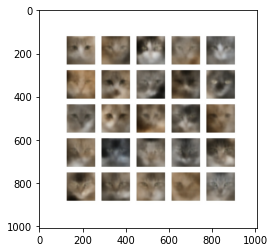

In [16]:
import matplotlib.pyplot as plt
import PIL
plt.imshow(PIL.Image.open('output1/Epoch_0019_step_0100.jpg'),aspect=1)

### Cat Generator Timelapse

In [3]:
#Visualize images after each epochs
import cv2

output_dir = "output1/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    cv2.waitKey()
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break